# Dogs vs. Cats
The training and testing data of this project is from a kaggle competetion https://www.kaggle.com/competitions/dogs-vs-cats. \
The goal of this project is to correctly recognise pictures of dogs and cats.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [8]:
# This cell is used on kaggle for unzip the dataset from the competition 
# https://www.kaggle.com/competitions/dogs-vs-cats
# silent the following commands if the data already exists
! unzip "../input/dogs-vs-cats/train.zip" -d dogs-vs-cats
! unzip "../input/dogs-vs-cats/test1.zip" -d dogs-vs-cats
!mv ./dogs-vs-cats/train ./dogs-vs-cats/orig_train

Archive:  ../input/dogs-vs-cats/train.zip
   creating: dogs-vs-cats/train/
  inflating: dogs-vs-cats/train/cat.0.jpg  
  inflating: dogs-vs-cats/train/cat.1.jpg  
  inflating: dogs-vs-cats/train/cat.10.jpg  
  inflating: dogs-vs-cats/train/cat.100.jpg  
  inflating: dogs-vs-cats/train/cat.1000.jpg  
  inflating: dogs-vs-cats/train/cat.10000.jpg  
  inflating: dogs-vs-cats/train/cat.10001.jpg  
  inflating: dogs-vs-cats/train/cat.10002.jpg  
  inflating: dogs-vs-cats/train/cat.10003.jpg  
  inflating: dogs-vs-cats/train/cat.10004.jpg  
  inflating: dogs-vs-cats/train/cat.10005.jpg  
  inflating: dogs-vs-cats/train/cat.10006.jpg  
  inflating: dogs-vs-cats/train/cat.10007.jpg  
  inflating: dogs-vs-cats/train/cat.10008.jpg  
  inflating: dogs-vs-cats/train/cat.10009.jpg  
  inflating: dogs-vs-cats/train/cat.1001.jpg  
  inflating: dogs-vs-cats/train/cat.10010.jpg  
  inflating: dogs-vs-cats/train/cat.10011.jpg  
  inflating: dogs-vs-cats/train/cat.10012.jpg  
  inflating: dogs-vs-cats/tr

The directory tree of original data is
<pre>.
└── dogs_vs_cats
     ├── test1
     │    ├── cat.jpg
     │    └── dog.jpg (12,500 files in total)       
     │           
     └── orig_train
          ├── cat.jpg
          └── dog.jpg (25,000 files in total)
</pre>

For easily running the calculation, the following cell is to convert the directory tree into as
<pre>.
└── dogs_vs_cats
     ├── test1
     │    ├── cat.jpg
     │    └── dog.jpg (12,500 files in total)       
     │           
     └── original_train
          ├── train
          │    ├── cat.jpg
          │    └── dog.jpg (20,000 files in total)
          └── validation
               ├── cat.jpg
               └── dog.jpg (5,000 files in total)
</pre>

If the original directory tree already works well, then mute next cell.

In [9]:
import shutil
rootdir= '/kaggle/working/dogs-vs-cats' #path to the original folder

os.makedirs(os.path.join(rootdir, "original_train", "train"))
os.makedirs(os.path.join(rootdir, "original_train", "validation"))
source = rootdir + "/orig_train"
# os.rename('/kaggle/working/dogs-vs-cats/train', source)

allFileNames = os.listdir(source)
print(allFileNames[:10])
np.random.shuffle(allFileNames)

val_ratio = 0.2

train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - val_ratio))])

train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

for name in train_FileNames:
    try:
        shutil.copy(name, rootdir + '/original_train/train/.')
    except:
        print(name)

for name in val_FileNames:
    try:
        shutil.copy(name, rootdir +'/original_train/validation/.')
    except:
        print(name)



['cat.10851.jpg', 'cat.3806.jpg', 'cat.9829.jpg', 'dog.6556.jpg', 'cat.4406.jpg', 'cat.10987.jpg', 'dog.10013.jpg', 'cat.3496.jpg', 'cat.11462.jpg', 'cat.1217.jpg']


In [10]:
# check if the files are correctly distributed to train and validation folder
rootdir= './dogs-vs-cats' #path to the original folder 
print(len(os.listdir(rootdir +'/orig_train/')))
print(len(os.listdir(rootdir +'/original_train/train/')))
print(len(os.listdir(rootdir +'/original_train/validation/')))

25000
20000
5000


# Define data augmentation and transformation for our calculation now
Here is doing a variety of transformation for data augmentation such rotate, flip, etc, and normalisation.

In [11]:
# Examne the data
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

### Start by creating a list

In [13]:
from torch.utils.data import Dataset

### Prepare training set, testing sets, and loaders

In [50]:
class myDataset(Dataset):
    
    def __init__(self,path,tfm=test_transform,files = None):
        super(myDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample", self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label1 = fname.split("/")[-1].split(".")[0]
            if label1 == 'dog':
                label = 1
            elif label1 == 'cat':
                label = 0
            else:
                label == label1
        except:
            label = -1 # test has no label
        return im, label

In [15]:
batch_size = 10
_dataset_dir = "/kaggle/working/dogs-vs-cats/original_train"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = myDataset(os.path.join(_dataset_dir,"train"), tfm=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = myDataset(os.path.join(_dataset_dir,"validation"), tfm=test_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One /kaggle/working/dogs-vs-cats/original_train/train sample /kaggle/working/dogs-vs-cats/original_train/train/cat.0.jpg
One /kaggle/working/dogs-vs-cats/original_train/validation sample /kaggle/working/dogs-vs-cats/original_train/validation/cat.1.jpg


Label: [1 0 1 0 0 1 1 0 0 0]


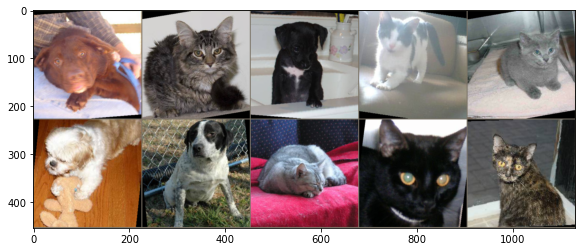

In [16]:
# Grab the first batch of 10 images
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
# print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Define model
# Use pretrained model

There are several pretrained models for image classification through <a href='https://pytorch.org/vision/stable/models.html'>torchvision.models </a> , such as
- AlexNet
- ConvNeXt
- DenseNet
- RegNet
- ResNet
- ResNeXt

Here I will use AlexNet pretrained model for the dog vs. cat classification task.

In [17]:
AlexNetmodel = models.alexnet(pretrained=True).to(device)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [19]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [20]:
# set up a function to look at number of parameters in model
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [21]:
# look at how many parameters in model
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


### Setup other parameters

In [22]:
# This is for the progress bar if.
from tqdm.auto import tqdm
import random

_exp_name = "cat_dog"

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

AlexNetmodel.to(device)
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

### Train model

In [19]:
# train the model
import time
start_time = time.time()

epochs = 30
best_acc = 0
stale = 0 # recode stale steps for hitting patience
patience = 20 # If no improvement in 'patience' epochs, early stop

# control the number of imported data for time save, if needed
max_trn_batch = 800 
max_val_batch = 300

train_losses = []
valid_losses = []
train_correct = []
valid_correct = []

for i in range(epochs):
    trn_corr = 0
    val_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i + 1:2}  training batch: {b:4} [{batch_size * b:6}/{batch_size * max_trn_batch:6}]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item() / (batch_size * b) * 100:7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the validation batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(valid_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            if b == max_val_batch:
                break
            
            b += 1
            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            val_corr += (predicted == y_test).sum()
            
            if b%100 == 0:
                print(f'epoch: {i + 1:2}  validation batch: {b:4} [{batch_size * b:6}/{batch_size * max_val_batch:6}]  loss: {loss.item():10.8f}  accuracy: {val_corr.item() / (batch_size * b) * 100:7.3f}%')

    loss = criterion(y_val, y_test)
    valid_losses.append(loss.item())
    valid_correct.append(val_corr.item())
    
    # extract the accuracy for the present epoch
    val_acc = val_corr.item() / (batch_size * b)
    
    # save models
    if val_acc > best_acc:
        best_acc = val_acc
        print(f"Best model found at epoch {i + 1}, saving model with val accuracy of {best_acc* 100:7.3f}%")
        torch.save(AlexNetmodel.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
    print('-' * 100)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  1  training batch:  200 [  2000/  8000]  loss: 0.13767412  accuracy:  88.400%
epoch:  1  training batch:  400 [  4000/  8000]  loss: 0.31585512  accuracy:  90.600%
epoch:  1  training batch:  600 [  6000/  8000]  loss: 0.07546721  accuracy:  91.467%
epoch:  1  training batch:  800 [  8000/  8000]  loss: 0.05671552  accuracy:  92.088%
epoch:  1  validation batch:  100 [  1000/  3000]  loss: 0.05671552  accuracy:  91.900%
epoch:  1  validation batch:  200 [  2000/  3000]  loss: 0.05671552  accuracy:  91.200%
epoch:  1  validation batch:  300 [  3000/  3000]  loss: 0.05671552  accuracy:  92.500%
Best model found at epoch 1, saving model with val accuracy of  92.500%
----------------------------------------------------------------------------------------------------
epoch:  2  training batch:  200 [  2000/  8000]  loss: 0.08442988  accuracy:  93.850%
epoch:  2  training batch:  400 [  4000/  8000]  loss: 0.00493916  accuracy:  93.825%
epoch:  2  training batch:  600 [  6000/  8000]

# Evaluate model performance

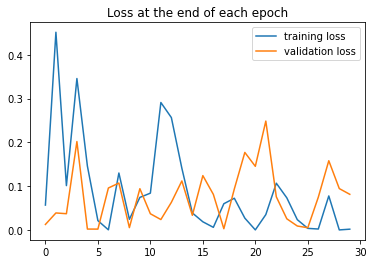

In [22]:
plt.plot(train_losses, label='training loss')
plt.plot(valid_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

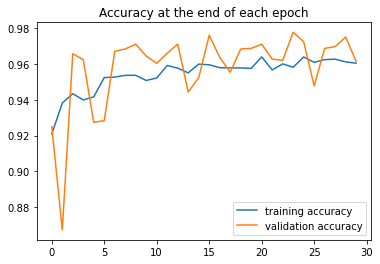

In [23]:
plt.plot([t/(max_trn_batch * batch_size) for t in train_correct], label='training accuracy')
plt.plot([t/(max_val_batch * batch_size) for t in valid_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [24]:
print(valid_correct)
print(f'Valid accuracy: {valid_correct[-1] / max_val_batch * 10:.3f}%')

[2775, 2602, 2897, 2887, 2782, 2785, 2901, 2905, 2913, 2893, 2881, 2898, 2913, 2833, 2857, 2928, 2891, 2866, 2905, 2906, 2913, 2888, 2886, 2933, 2917, 2843, 2906, 2909, 2925, 2884]
Valid accuracy: 96.133%


# Prediction for the test1 data
Here I will use the trained model to classify the images in the folder test1, and compare the predicted results to the real results in csv file "sampleSubmission.csv".

In [43]:
# load the best-performing model
model_tuned_alexnet = models.alexnet()
model_tuned_alexnet.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
model_tuned_alexnet.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_tuned_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [44]:
# first look at how many data in the test1 folder and the csv file
testData_path = '/kaggle/working/dogs-vs-cats/test1'
test_csv = '/kaggle/input/dogs-vs-cats/sampleSubmission.csv'
df_test = pd.read_csv(test_csv)

print(df_test.shape[0])
print(len(os.listdir(testData_path)))

12500
12500


(381, 499)


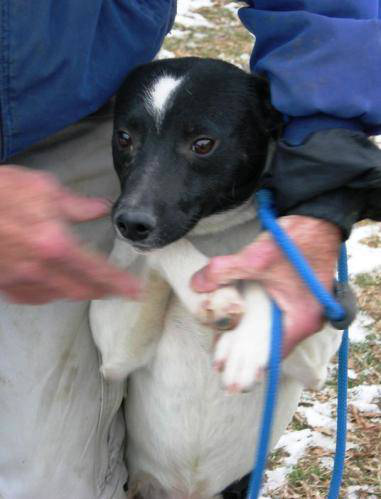

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [45]:
# check if the label in the test set is consistent to training set
test_image = Image.open(testData_path +'/1.jpg')
print(test_image.size)
display(test_image)
display(df_test.head())

In [52]:
# create test data
batch_size = 10
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = myDataset(testData_path, tfm=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
print(len(test_loader))

One /kaggle/working/dogs-vs-cats/test1 sample /kaggle/working/dogs-vs-cats/test1/1.jpg
1250


In [53]:
# Run prediction for test1 folder
test_predict = []
with torch.no_grad():
    for b, (imgFile, fileId) in enumerate(test_loader):
        imgFile, fileId = imgFile.to(device), fileId.to(device)

        # Apply the model
        y_pred = AlexNetmodel(imgFile)

        # Tally the number of correct predictions
        _, predicted = torch.max(y_pred.data, 1)
        
        
        # extract and save predicted label into list
        for y in predicted.cpu().numpy():
        # The label in the csv file is {dog:0, cat:1}, different from the model {dog:1, cat:0}, need to switch model's label
            if y == 0:
                y == 1
            elif y == 1:
                y == 0
            test_predict.append(y)

Just find... \
The label in sampleSubmission.csv is not correct, all labels are0, no 1. Thus, I can not do prediction for test.\
To do prediction for the test dataset, it is the same way as predict validation set and get labels. \

I still write how to look at accuracy of prediction below cell.

In [67]:
# check the number of predicted results
print(len(test_predict))

# Here is how to look at the accuracy for prediction
track = 0
for i, real_label in enumerate(df_test['label']):
    if real_label == test_predict[i]:
        track += 1
        
print('Accuracy = ', track / len(test_predict) * 100, ' %')

12500
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
